# Checking inference results on GW test set from Yu and Zunger

This is just to fully confirm that the FT deltas are more appropriate to use than the Kim deltas

In [3]:
from jarvis.db.jsonutils import dumpjson
from jarvis.db.jsonutils import loadjson
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn.metrics import r2_score
from scipy.integrate import simps


In [4]:
def csv_pred(f_path, s_file, scale=True):
    f_file = f_path+"val_preds.csv"
    df = pd.read_csv(f_file)
    id_preds = {}
    for id in df['0'].values:
        row = df.loc[df['0'] ==id].to_numpy().tolist()[0]
        if scale:
            stat_dict = loadjson(s_file)
            mu = np.array(stat_dict['mean/s'])
            sig = np.array(stat_dict['std/s'])
            unscaled = np.array(row[1:]) * sig + mu
            id_preds[id] = unscaled
        else:
            id_preds[id] = row[1:]
    return id_preds

In [5]:
def rank(pred_array,id_dict):
    pred = {}
    true = {}
    for id in id_dict:
        index = id_dict[id]
        true[id] = pred_array[index,0]
        pred[id] = pred_array[index,1]
    s_trues = {k: v for k, v in sorted(true.items(), key=lambda item: item[1], reverse = True)}
    s_preds = {k: v for k, v in sorted(pred.items(), key=lambda item: item[1], reverse = True)}
    rank_dict = {}
    diff_dict = {}
    for id in true:
        pred_rank = list(s_preds.keys()).index(id)
        true_rank = list(s_trues.keys()).index(id)
        rank_dict[id] = pred_rank - true_rank
        diff_dict[id] = pred[id] - true[id]
    s_rank_dict = {k: v for k, v in sorted(rank_dict.items(), key=lambda item: item[1], reverse = True)}
    s_diff_dict = {k: v for k, v in sorted(diff_dict.items(), key=lambda item: item[1], reverse = True)}
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle("Differences in raw numbers and in rankings")
    axs[0].hist(s_diff_dict.values())
    axs[0].set_xlabel('Raw differences')
    axs[1].hist(s_rank_dict.values())
    axs[1].set_xlabel('Differences in ranks')
    return s_diff_dict, s_rank_dict

In [6]:
def MAE(targ, pred):
    mae = 0
    for t,p in zip(targ,pred):
        mae += abs(t-p)
    mae = mae/len(targ)
    return mae

## SLME predicitions

In [7]:
kim_slme_preds = csv_pred('Kim_etas/','../properties/scaling_files/Kim_etas_stats.json')

In [8]:
ft_slme_preds = csv_pred('FT_etas/','../properties/scaling_files/FT_etas_stats.json')

In [9]:
slme_true = loadjson('data/Yu_test_dict.json')

In [10]:
rows = []
index = 0
id_dict = {}
for id,slme in kim_slme_preds.items():
    rows.append([slme_true[str(id)],slme.item()])
    id_dict[id] = index
    index+=1
kim_eta_array = np.array(rows)

In [11]:
rows = []
index = 0
id_dict = {}
for id,slme in ft_slme_preds.items():
    rows.append([slme_true[str(id)],slme.item()])
    id_dict[id] = index
    index+=1
ft_eta_array = np.array(rows)

Text(0.5, 1.0, 'MAE 10.556813781955332')

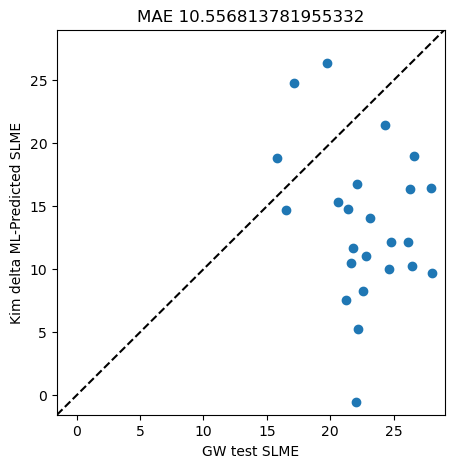

In [12]:
plt.figure(figsize=(5,5))
plt.scatter(kim_eta_array[:,0],kim_eta_array[:,1])
plt.xlim(np.min(kim_eta_array)-1,np.max(kim_eta_array)+1)
plt.ylim(np.min(kim_eta_array)-1,np.max(kim_eta_array)+1)
plt.plot([np.min(kim_eta_array)-1,np.max(kim_eta_array)+1],[np.min(kim_eta_array)-1,np.max(kim_eta_array)+1],'--k')
plt.xlabel('GW test SLME')
plt.ylabel('Kim delta ML-Predicted SLME')
plt.title(f'MAE {MAE(kim_eta_array[:,0], kim_eta_array[:,1])}')

Text(0.5, 1.0, 'MAE 6.1503823429238365')

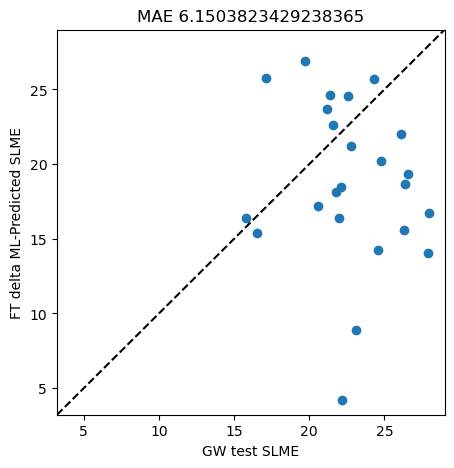

In [13]:
plt.figure(figsize=(5,5))
plt.scatter(ft_eta_array[:,0],ft_eta_array[:,1])
plt.xlim(np.min(ft_eta_array)-1,np.max(ft_eta_array)+1)
plt.ylim(np.min(ft_eta_array)-1,np.max(ft_eta_array)+1)
plt.plot([np.min(ft_eta_array)-1,np.max(ft_eta_array)+1],[np.min(ft_eta_array)-1,np.max(ft_eta_array)+1],'--k')
plt.xlabel('GW test SLME')
plt.ylabel('FT delta ML-Predicted SLME')
plt.title(f'MAE {MAE(ft_eta_array[:,0], ft_eta_array[:,1])}')

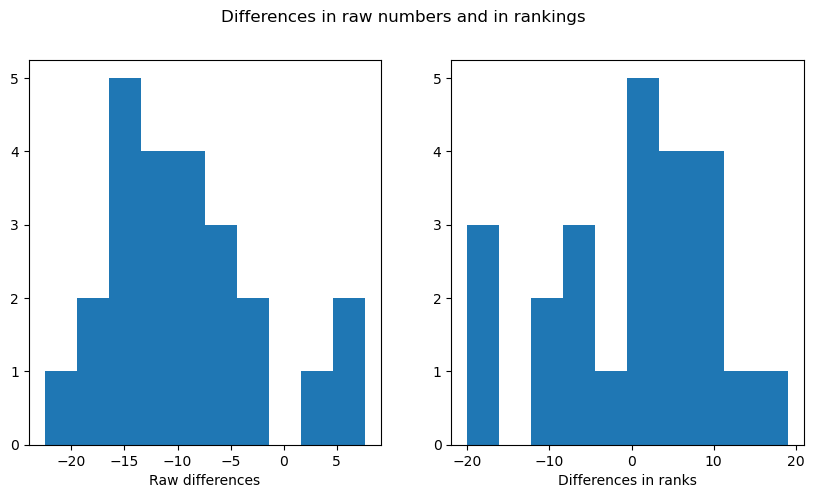

In [14]:
diff_dict,rank_dict = rank(kim_eta_array,id_dict)

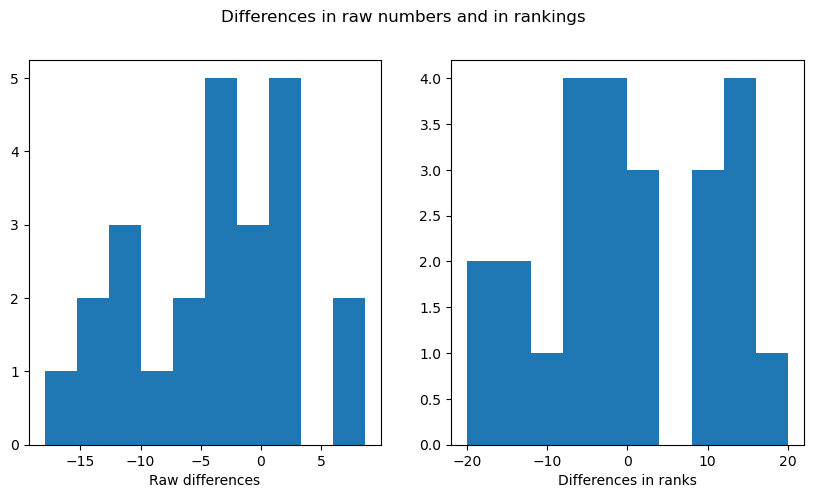

In [15]:
diff_dict,rank_dict = rank(ft_eta_array,id_dict)

## Offset predictions

In [16]:
kim_delta_preds = csv_pred('Kim_deltas/','../properties/scaling_files/Kim_deltas_stats.json')

In [17]:
kim_u_delta_preds = csv_pred('Kim_deltas/unscaled/','../properties/scaling_files/Kim_deltas_stats.json',scale=False)

In [18]:
kim_zi_delta_preds = csv_pred('Kim_deltas/ZI/', '../properties/scaling_files/Kim_deltas_stats.json',scale=False)

In [19]:
ft_delta_preds = csv_pred('FT_deltas/','../properties/scaling_files/FT_deltas_stats.json')

In [20]:
ft_u_delta_preds = csv_pred('FT_deltas/unscaled/','../properties/scaling_files/FT_deltas_stats.json',scale=False)
ft_zi_delta_preds = csv_pred('FT_deltas/ZI/','../properties/scaling_files/FT_deltas_stats.json',scale=False)

In [21]:
delta_true = loadjson('data/Yu_offsets.json')

In [22]:
rows = []
index = 0
id_dict = {}
for id,delta in kim_delta_preds.items():
    rows.append([delta_true[str(id)],delta.item()])
    id_dict[id] = index
    index+=1
kim_delta_array = np.array(rows)

In [23]:
rows = []
index = 0
id_dict = {}
for id,delta in kim_u_delta_preds.items():
    rows.append([delta_true[str(id)],delta[0]])
    id_dict[id] = index
    index+=1
kim_u_delta_array = np.array(rows)

In [24]:
rows = []
index = 0
id_dict = {}
for id,delta in kim_zi_delta_preds.items():
    rows.append([delta_true[str(id)],delta[0]])
    id_dict[id] = index
    index+=1
kim_zi_delta_array = np.array(rows)

In [25]:
rows = []
index = 0
id_dict = {}
for id,delta in ft_delta_preds.items():
    rows.append([delta_true[str(id)],delta.item()])
    id_dict[id] = index
    index+=1
ft_delta_array = np.array(rows)

In [26]:
rows = []
index = 0
id_dict = {}
for id,delta in ft_u_delta_preds.items():
    rows.append([delta_true[str(id)],delta[0]])
    id_dict[id] = index
    index+=1
ft_u_delta_array = np.array(rows)

In [27]:
rows = []
index = 0
id_dict = {}
for id,delta in ft_zi_delta_preds.items():
    rows.append([delta_true[str(id)],delta[0]])
    id_dict[id] = index
    index+=1
ft_zi_delta_array = np.array(rows)

In [28]:
def plot_delta_scatter(axis, dataset, method, array,tolerance):
    axis.scatter(array[:,0],array[:,1])
    axis.set_xlim(np.min(array)-tolerance,np.max(array)+tolerance)
    axis.set_ylim(np.min(array)-tolerance,np.max(array)+tolerance)
    axis.plot([np.min(array)-tolerance,np.max(array)+tolerance],[np.min(array)-tolerance,np.max(array)+tolerance],'--k')
    axis.set_xlabel(r'GW test $\Delta E$ / eV')
    axis.set_ylabel(f'{dataset} ML-Predicted offset / eV')
    axis.set_title(f'{method}: MAE {MAE(array[:,0], array[:,1]):.2f}')

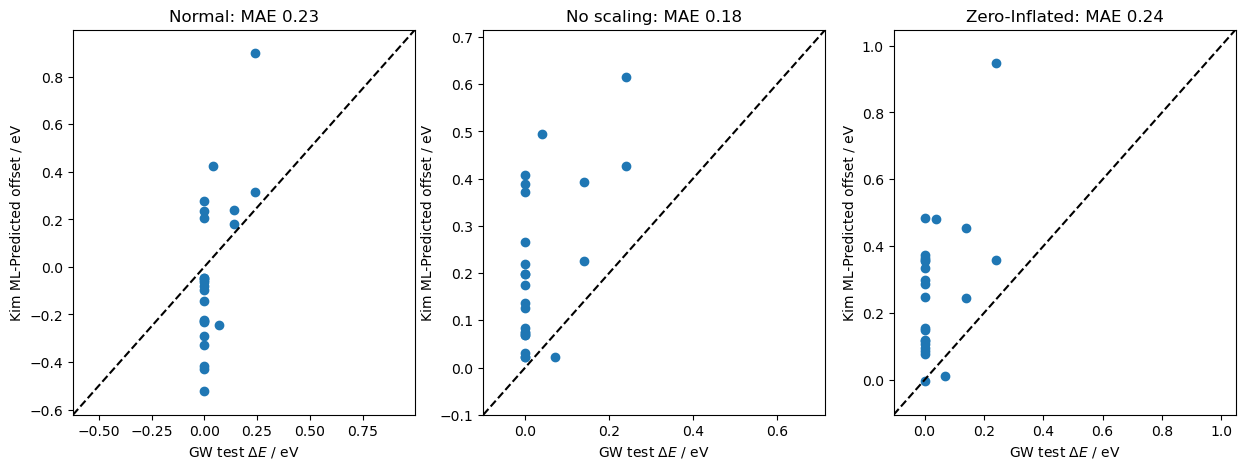

In [29]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
plot_delta_scatter(axs[0],'Kim', 'Normal', kim_delta_array,0.1)
plot_delta_scatter(axs[1],'Kim', 'No scaling', kim_u_delta_array,0.1)
plot_delta_scatter(axs[2],'Kim', 'Zero-Inflated', kim_zi_delta_array,0.1)
fig.align_ylabels(axs)

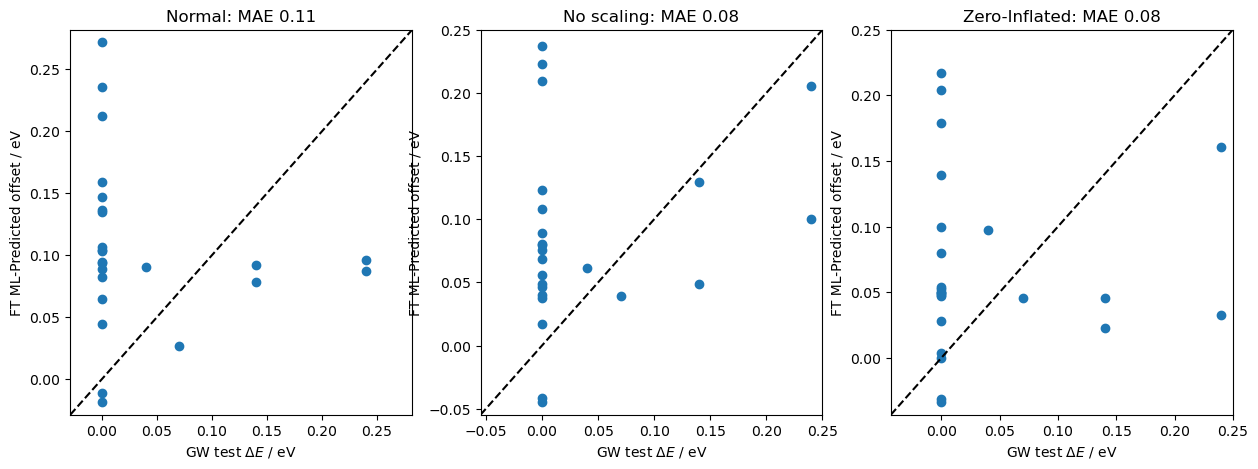

In [30]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
plot_delta_scatter(axs[0],'FT', 'Normal', ft_delta_array,0.01)
plot_delta_scatter(axs[1],'FT', 'No scaling', ft_u_delta_array,0.01)
plot_delta_scatter(axs[2],'FT', 'Zero-Inflated', ft_zi_delta_array,0.01)

## Raw offsets

In [34]:
FT_deltas = loadjson('/home/matthew/mpcontribs-downloads/FT_delta_Es.json')

In [35]:
yu_mpids = list(delta_true.keys())

In [37]:
len(set(yu_mpids).intersection(set(FT_deltas.keys())))

0